In [2]:
%pip install datasets datasets[vision] transformers tqdm pandas torch transformers[torch] torchvision evaluate


zsh:1: no matches found: datasets[vision]


Note: you may need to restart the kernel to use updated packages.


In [121]:
from datasets import load_dataset
from transformers import AutoImageProcessor, AutoModelForImageClassification, TrainingArguments, Trainer, pipeline
import evaluate

import torch
from torchvision.transforms import CenterCrop, Compose, Normalize, Resize, ToTensor
from torchvision.transforms.functional import adjust_saturation, adjust_contrast, adjust_sharpness, equalize

from IPython.display import display
from tqdm import tqdm

import pandas as pd
import numpy as np



Resolving data files: 100%|██████████| 1921/1921 [00:00<00:00, 339524.59it/s]


{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=2144x1424 at 0x19C25D1D0>, 'Disease_Risk': 1, 'DR': 1, 'ARMD': 0, 'MH': 0, 'DN': 0, 'MYA': 0, 'BRVO': 0, 'TSLN': 0, 'ODC': 0}


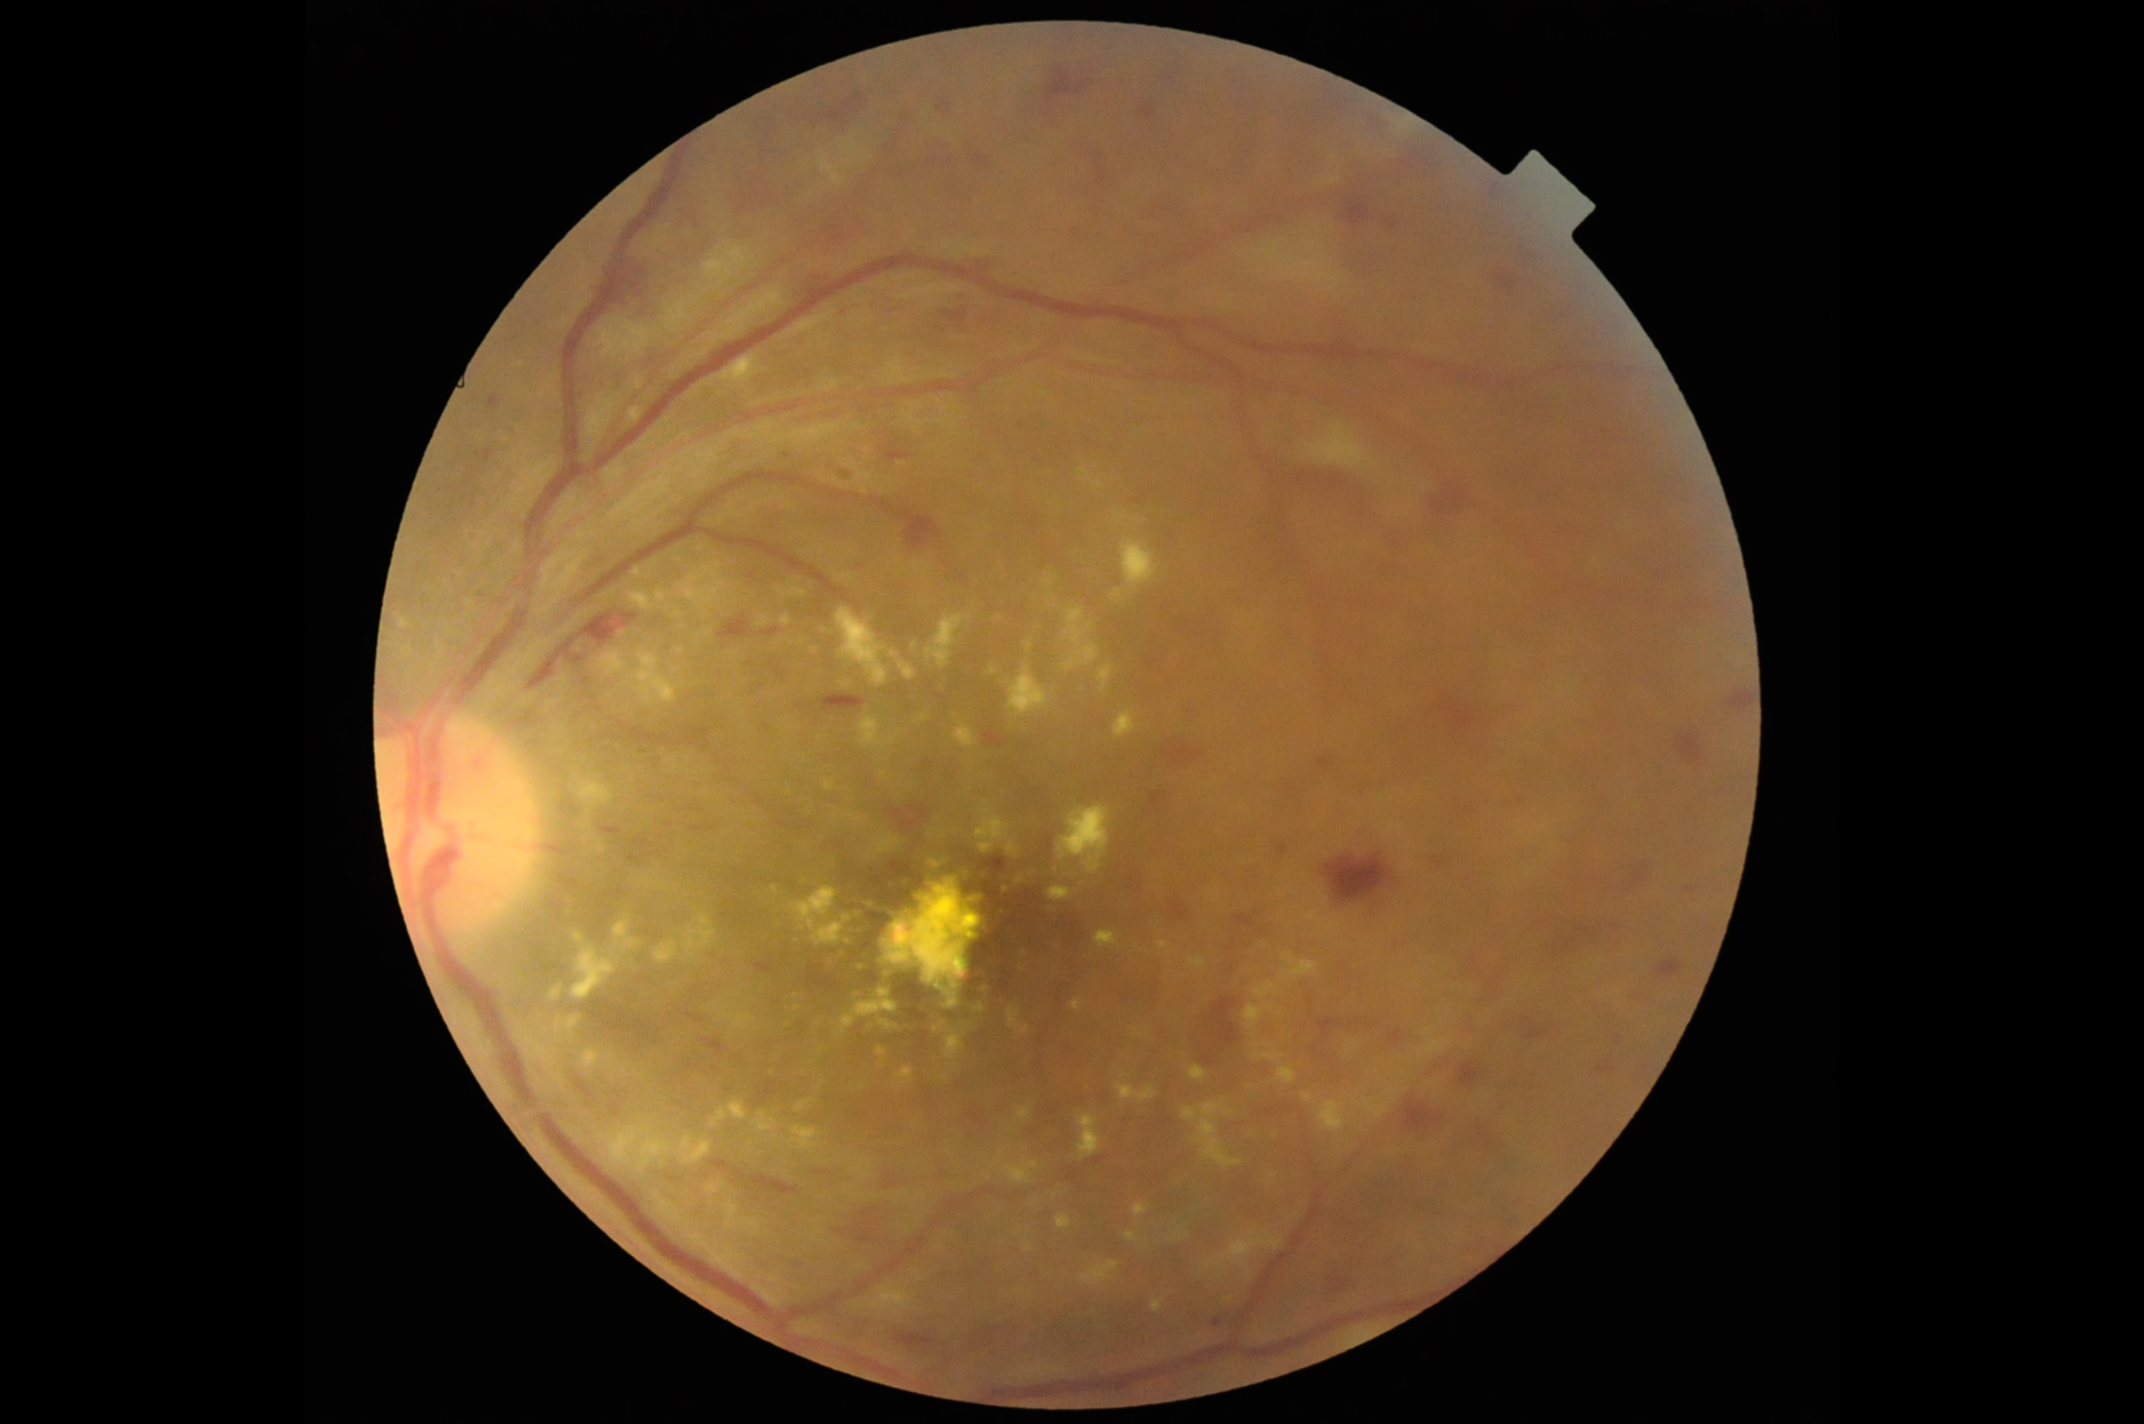

In [122]:
model_checkpoint = "microsoft/resnet-50"
batch_size = 32

metric_accuracy = evaluate.load("accuracy")
metric_f1 = evaluate.load("f1")
metric_precision = evaluate.load("precision")
metric_recall = evaluate.load("recall")
# Because of a bug in HuggingFace's evaluate library, we cannot combine them automatically.
# See https://discuss.huggingface.co/t/combining-metrics-for-multiclass-predictions-evaluations/21792/11
# metric = evaluate.combine(["accuracy", "f1", "precision", "recall"])

labels = ["Disease_Risk", "DR", "ARMD", "MH", "DN", "MYA", "BRVO", "TSLN", "ERM", "LS", "MS", "CSR", "ODC", "CRVO", "TV", "AH", "ODP", "ODE", "ST", "AION", "PT", "RT", "RS", "CRS", "EDN", "RPEC", "MHL", "RP", "CWS", "CB", "ODPM", "PRH", "MNF", "HR", "CRAO", "TD", "CME", "PTCR", "CF", "VH", "MCA", "VS", "BRAO", "PLQ", "HPED", "CL"]
# > 75 examples in the training set
significant_labels = ["Disease_Risk", "DR", "ARMD", "MH", "DN", "MYA", "BRVO", "TSLN", "ODC"]

dataset = load_dataset("imagefolder", data_dir="./datasets/training")

# Keep only 1/4 of the dataset for faster training for now
# dataset['train'] = dataset['train'].select(range(0, len(dataset['train']), 4))

# Keep only the columns which are in significant_labels
dataset = dataset.map(remove_columns=[x for x in labels if x not in significant_labels])
print(dataset['train'][0])

display(dataset['train'][0]['image'])


In [123]:
label2id, id2label = dict(), dict()
for i, label in enumerate(significant_labels):
    label2id[label] = i
    id2label[i] = label


In [124]:
image_processor = AutoImageProcessor.from_pretrained(model_checkpoint)

if "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    max_size = image_processor.size.get("longest_edge")

transforms = Compose([
    Resize(size),
    CenterCrop((size, size))
])
transforms2 = Compose([
    ToTensor(),
    Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
])
# train_transforms = Compose([
#     Resize(size),
#     CenterCrop((size, size)),
#     ToTensor(),
#     Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
# ])
# val_transforms = Compose([
#     Resize(size),
#     CenterCrop((size, size)),
#     ToTensor(),
#     Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
# ])

def transform(image):
    image = transforms(image.convert("RGB"))
    image = adjust_sharpness(image, 60)
    image = adjust_contrast(image, 1.4)
    image = equalize(image)
    image = adjust_gamma(image, 2)
    return transforms2(image.convert("HSV"))

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [transform(image) for image in example_batch["image"]]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [transform(image) for image in example_batch["image"]]
    return example_batch


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [126]:
splits = dataset["train"].train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)


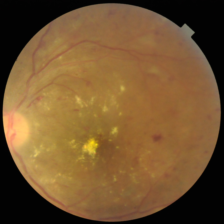

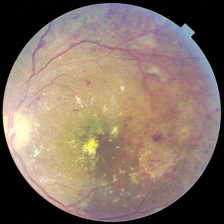

In [127]:
image = dataset['train'][0]['image'].convert("RGB")
debug_transforms = Compose([
    Resize(size),
    CenterCrop((size, size)),
])
display(debug_transforms(image))

image = adjust_sharpness(image, 60)
image = adjust_contrast(image, 1.4)
image = equalize(image)
image = adjust_gamma(image, 2)
display(debug_transforms(image))


In [128]:
model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)
model.config.problem_type = "multi_label_classification"


Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([9, 2048]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([9]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [129]:
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name[:-1]}3",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
)

# The `compute_metrics` function takes a Named Tuple as input:
# `predictions`, which are the logits of the model as Numpy arrays,
# `label_ids`, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    references = np.argmax(eval_pred.label_ids, axis=1)
    results = {}
    results.update(metric_accuracy.compute(predictions=predictions, references=references))
    results.update(metric_f1.compute(predictions=predictions, references=references, average="micro"))
    results.update(metric_precision.compute(predictions=predictions, references=references, average="micro"))
    results.update(metric_recall.compute(predictions=predictions, references=references, average="micro"))
    return results


#### Averaging strategies
_Generated by ChatGPT_

The average parameter is related to how you want to aggregate the individual metric scores when dealing with multiclass or multilabel classification tasks. The three common options for the "average" parameter are:

1. "macro": This option calculates the metric for each class independently and then takes the unweighted mean of those values. In other words, it treats all classes equally, regardless of their prevalence in the dataset. It's a good choice when you want to ensure that each class's performance is considered independently.

2. "micro": This option calculates the metric by summing up the contributions of each class and then computes the metric. It takes into account the overall performance across all classes. This is useful when you have imbalanced datasets, and you want to emphasize the performance of the majority class.

3. "weighted": This computes the metric for each class separately, but it assigns a weight to each class based on its prevalence in the dataset. This means that more common classes have a greater impact on the final metric. It's a good choice when you want to consider class imbalance and want the metric to reflect the dataset's true distribution.

The choice of which "average" parameter to use depends on the specific characteristics of your dataset and the goals of your classification task:
- If your dataset is well-balanced (i.e., each class has roughly the same number of examples), "macro" averaging may be appropriate as it treats all classes equally.
- If your dataset is highly imbalanced, "micro" or "weighted" averaging may be more appropriate. "Micro" emphasizes overall performance, while "weighted" considers the class distribution.

In [130]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    expl_labels = torch.tensor([[float(example[label]) for label in significant_labels] for example in examples])
    return {"pixel_values": pixel_values, "labels": expl_labels}


In [131]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)


In [92]:
train_results = trainer.train()
# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.log_metrics("eval", train_results.metrics)
trainer.save_metrics("eval", train_results.metrics)
trainer.save_state()


                                      
  0%|          | 0/39 [18:29<?, ?it/s]         

{'loss': 0.692, 'learning_rate': 4.1428571428571437e-05, 'epoch': 0.74}








                                      

                                       
  0%|          | 0/39 [24:38<?, ?it/s]         



{'eval_loss': 0.671970546245575, 'eval_accuracy': 0.796875, 'eval_f1': 0.796875, 'eval_precision': 0.796875, 'eval_recall': 0.796875, 'eval_runtime': 75.5033, 'eval_samples_per_second': 2.543, 'eval_steps_per_second': 0.079, 'epoch': 0.96}


KeyboardInterrupt: 

In [ ]:
new_size = 224

def resize_pil_image(image):
    aspect_ratio = image.size[0] / image.size[1]
    new_width = int(new_size * aspect_ratio)
    left = (new_width - new_size) / 2
    right = (new_width + new_size) / 2

    return image.resize((new_width, new_size)) \
                .crop((left, 0, right, new_size)) \
                .resize((new_size, new_size))

def get_labels(example):
    return [label for label in significant_labels if example[label] == 1]


Resolving data files: 100%|██████████| 641/641 [00:00<00:00, 157964.09it/s]


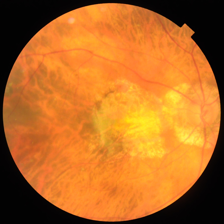

✅ Disease_Risk: 17.08%
❌ ODP: 9.23%
❌ ODC: 8.88%
❌ TSLN: 8.84%
❌ MH: 8.84%

Missing labels: ARMD, MYA


In [ ]:
ds = load_dataset("imagefolder", data_dir="./datasets/test")
entry = ds['train'][13]
image = entry["image"]

correct_labels = get_labels(entry)

image = resize_pil_image(image)
display(image)

classifier = pipeline("image-classification", model="resnet-50-finetuned-eye-disease-2")
result = classifier(image)

for entry in result:
    label = entry['label']
    score = entry['score']
    print(f"{'✅' if label in correct_labels else '❌'} {label}: {float(score) * 100:.2f}%")

print('\nMissing labels:', ', '.join([x for x in correct_labels if x not in [x['label'] for x in result]]))


In [ ]:
ds = load_dataset("imagefolder", data_dir="./datasets/test")

def preprocess_test(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("HSV")) for image in example_batch["image"]]
    return example_batch

ds.set_transform(preprocess_test)

results = trainer.predict(ds['train'])
predictions = np.argmax(results.predictions, axis=1)
references = np.argmax(results.label_ids, axis=1)


Resolving data files: 100%|██████████| 641/641 [00:00<00:00, 170118.25it/s]
22it [04:30, 12.28s/it]                        


In [ ]:
print("accuracy: ", metric_accuracy.compute(predictions=predictions, references=references))
print("f1 (average=micro): ", metric_f1.compute(predictions=predictions, references=references, average="micro"))
print("precision (average=micro): ", metric_precision.compute(predictions=predictions, references=references, average="micro"))
print("recall (average=micro): ", metric_recall.compute(predictions=predictions, references=references, average="micro"))


accuracy:  {'accuracy': 1.0}
f1 (average=micro):  {'f1': 1.0}
precision (average=micro):  {'precision': 1.0}
recall (average=micro):  {'recall': 1.0}


In [ ]:
ds = load_dataset("imagefolder", data_dir="./datasets/test")

# Test all images in the test dataset

# Dataframe with shape {image: image, true_labels: [label1, label2, ...], predicted_labels: [(label1, score1), (label2, score2), ...]}
df = pd.DataFrame(columns=['image', 'true_labels', 'predicted_labels'])

for i, entry in tqdm(enumerate(ds['train'])):
    image = resize_pil_image(entry['image'])
    correct_labels = get_labels(entry)

    result = classifier(image)

    predicted_labels = [(x['label'], x['score']) for x in result]
    df.loc[i] = [image, correct_labels, predicted_labels]


Resolving data files: 100%|██████████| 641/641 [00:00<00:00, 294312.96it/s]
640it [04:06,  2.60it/s]


In [ ]:
# Show results
# for i, row in df.iterrows():
#     print(f"Image {i}")
#     display(row['image'])

#     print("True labels:", row['true_labels'])
#     print("Predicted labels:", [x[0] for x in row['predicted_labels']])
#     print("Predicted scores:", [x[1] for x in row['predicted_labels']])
#     print()

df['predicted_labels_score'] = df['predicted_labels'].apply(lambda x: x[0][1])
# Sort the DataFrame based on the first predicted label score
df = df.sort_values(by='predicted_labels_score', ascending=False)
df = df.drop(columns=['predicted_labels_score'])

df.head()


# Compute the correctness of the first 3 predicted label
correctness = [0, 0, 0]

for i, row in df.iterrows():
    for j in range(3):
        if row['predicted_labels'][j][0] in row['true_labels']:
            correctness[j] += 1

for i in range(3):
    correctness[i] /= len(df)
    print(f"Correctness of the {i + 1}{'st' if i == 0 else 'nd' if i == 1 else 'rd'} predicted label: {correctness[i] * 100:.2f}%")



Accuracy of the 1st predicted label: 79.06%
Accuracy of the 2nd predicted label: 7.97%
Accuracy of the 3rd predicted label: 8.91%
